In [1]:
import os
import re
import time
import json
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import os.path as osp

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as patches
from sklearn.metrics import r2_score

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import torch
from torch.utils.data import DataLoader
from torchsummary import summary

from dataset import E33OMA, E33OMA90D, E33OMA_CRNN, E33OMA90D_CRNN
from model import Discriminator, Generator, UNet, ConvLSTM
from utils import seed, load_checkpoint, plot_global_ave, qqplot, find_nearest, plot_on_grid, make_saving_path

### List of current trained models

In [2]:
def natural_sort_key(s):
    # Split the string into segments of digits and non-digits
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

models_path_root = '/home/serfani/serfani_data1/snapshots'
# List directory contents
dir_contents = os.listdir(models_path_root)

# Sort using the custom sort key
sorted_contents = sorted(dir_contents, key=natural_sort_key)

# Print sorted contents
for idx, model in enumerate(sorted_contents):
    print(idx, model)

0 LSTM-64K5.32K3.16K3-E33OMA90D-5C-BCB-20241014-1247
1 LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
2 LSTM-64K5.32K3.16K3-E33OMA-8C-BCB-20240719-1241
3 UNet-E33OMA-5C-BCB-20240718-1527


In [3]:
model_index = 1
model_name  = sorted_contents[model_index]
save_figure = False

# Read the JSON file
with open(osp.join(models_path_root, model_name, 'configurations.json'), 'r') as file:
    data = json.load(file)

# Create variables dynamically
for key, value in data.items():
    globals()[key] = value

# Print dynamically created variables
for key in data.keys():
    print(f'{key}: {globals()[key]}')

model: LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
species: bcb
learning_rate: 0.001
dataset: E33OMA
in_channels: 5
hidden_channels: [64, 32, 16]
kernel_size: [5, 3, 3]
num_layers: 3
sequence_length: 48
transform: False
num_epochs: 30
input_size: [100, 154]
batch_size: 8
num_workers: 1
scheduler_config: [10.0, 0.5]
betas: [0.5, 0.999]
use_checkpoint: False
snapshot_dir: /home/serfani/serfani_data1/snapshots/LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
restore_from: /home/serfani/serfani_data1/snapshots/LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949


In [4]:
with open(osp.join(snapshot_dir, 'logger.npy'), mode='rb') as f:
    
    mse_loss = np.load(f, allow_pickle=True)
    r2_scores_trn = np.load(f, allow_pickle=True)
    r2_scores_val = np.load(f, allow_pickle=True)

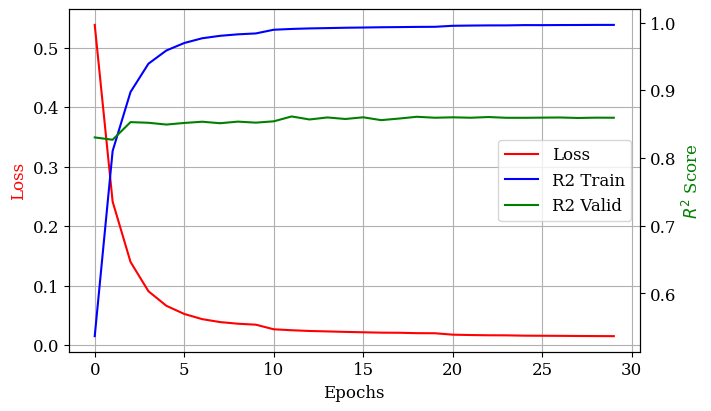

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(ncols=1, figsize=(7, 4), constrained_layout=True)

lns1 = ax1.plot(mse_loss, 'r', label='Loss')

ax2 = ax1.twinx()
lns2 = ax2.plot(r2_scores_trn, 'b', label='R2 Train')
lns3 = ax2.plot(r2_scores_val, 'g', label='R2 Valid')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel(r'$R^2$ Score', color='g')

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=5)
ax1.grid()

if save_figure:
    plt.savefig(osp.join(snapshot_dir, '00-loss_decay_landscape.png'))

plt.show()

In [5]:
seed()

if model.split('-')[0] == 'UNet':
    net = UNet(in_channels=in_channels).cuda()

if model.split('-')[0] == 'LSTM':
    net = ConvLSTM(in_channels, hidden_channels, kernel_size, num_layers).cuda()

load_checkpoint(osp.join(snapshot_dir, f'epoch-{num_epochs:003d}', 'generator.pth.tar'), net)

Number of Epochs:  30
Learning Rate:  [0.000125]


In [6]:
# Dataloader
if (dataset == 'E33OMA' and model.split('-')[0] == 'UNet'):
    dataset = E33OMA(period='test', species=species, padding=input_size, in_channels=in_channels, transform=transform)

if (dataset == 'E33OMA90D' and model.split('-')[0] == 'UNet'):
    dataset = E33OMA90D(period='test', species=species, padding=input_size, in_channels=in_channels, transform=transform)

if (dataset == 'E33OMA' and model.split('-')[0] == 'LSTM'):
    dataset = E33OMA_CRNN(period='test', species=species, padding=input_size, in_channels=in_channels, sequence_length=sequence_length)

if (dataset == 'E33OMA90D' and model.split('-')[0] == 'LSTM'):
    dataset = E33OMA90D_CRNN(period='test', species=species, padding=input_size, in_channels=in_channels, sequence_length=sequence_length)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False) # for in_channel=6, batch_size MUST be 1

In [ ]:
# Preallocation
total_samples = len(dataloader.dataset)

GTs = np.empty((total_samples, 1, 90, 144))
PDs = np.empty((total_samples, 1, 90, 144))
HSs = np.empty((total_samples, 48, 90, 144)) # (1, 48, 90, 144)

net.eval()

sample_index = 0
with torch.no_grad():
    for counter, (X, y) in enumerate(dataloader, 1):

        batch_size = X.shape[0]

        if (model.split('-')[0] == 'UNet' and in_channels == 6 and counter != 1):
            X[:, -1] = pred

        X = X.cuda()        
        y = y.cuda()

        pred, hs = net(X)

        if model.split('-')[0] in ['PIX2PIX', 'UNet']:
            p = pred[:, :, 83:83+90, 56:56+144].clone()
        
        elif model.split('-')[0] in ['LSTM']:
            p = pred[:, :, 5:5+90, 5:5+144].clone().squeeze()
            h = hs[:, :, 5:5+90, 5:5+144].clone().squeeze()

        # Detach the output from computational graph ad deploy it to CPU as a numpy array
        y = (y.detach().cpu().numpy() * dataset.y_std) + dataset.y_mean
        p = (p.detach().cpu().numpy() * dataset.y_std) + dataset.y_mean
        h = (h.detach().cpu().numpy() * dataset.y_std) + dataset.y_mean

        GTs[sample_index:sample_index+batch_size] = y
        PDs[sample_index:sample_index+batch_size] = p
        HSs[sample_index:sample_index+batch_size] = h
        
        sample_index += batch_size
        
print(GTs.shape, PDs.shape, HSs.shape)

In [109]:
with open(os.path.join(snapshot_dir, 'test-results-h.npy'), mode = 'wb') as f:

    np.save(f, GTs)
    np.save(f, PDs)
    np.save(f, HSs)

In [9]:
with open(osp.join(snapshot_dir, 'test-results.npy'), mode='rb') as f:
    
    GTs = np.load(f, allow_pickle=True)
    PDs = np.load(f, allow_pickle=True)
    # HSs = np.load(f, allow_pickle=True)

# print(GTs.shape, PDs.shape, HSs.shape)
print(GTs.shape, PDs.shape)

(15721, 1, 90, 144) (15721, 1, 90, 144)


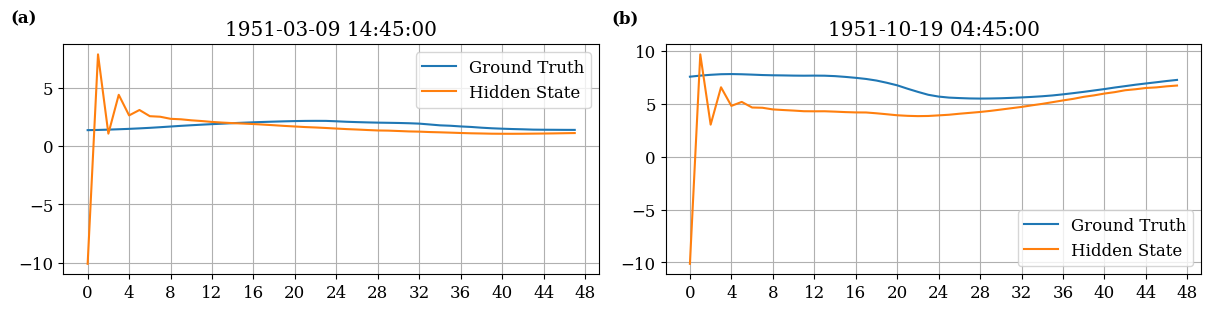

In [151]:
# Set the random seed for reproducibility
rng = np.random.default_rng(seed=42)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), constrained_layout=True)

axs = axs.ravel()
idxs = rng.integers(48, 15721, size=4)
caption = ['(a)', '(b)', '(c)', '(d)']

for idx, ax in enumerate(axs):
    ax.set_aspect('auto')
    ax.set_title(f'{dataset.datetimeindex[idxs[idx]]}')
    
    hs = HSs[idxs[idx]].mean(axis=(1, 2))
    gt = GTs[idxs[idx]-48:idxs[idx]].squeeze().mean(axis=(1, 2))
    
    ax.plot(gt, label='Ground Truth')
    ax.plot(hs, label='Hidden State')
   
    ax.xaxis.set_major_locator(MaxNLocator(nbins=48))
    ax.set_xticks(np.arange(0, 49, step=4))
    ax.set_xticklabels([str(i) for i in range(0, 49, 4)])

    ax.text(-0.05, 1.15, f'{caption[idx]}', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

    ax.legend()
    ax.grid()

plt.show()



In [7]:
def r_squared_temporal(gts, pds):
    
    import pandas as pd
    r_squared_temporal = np.empty((gts.shape[0]))

    for i, gt in enumerate(gts):
        r_squared_temporal[i] = r2_score(gt.flatten(), pds[i].flatten())

    return pd.Series(r_squared_temporal)


In [10]:
r_squared_temporal(GTs, PDs).describe()

count    15721.000000
mean         0.854474
std          0.081106
min         -0.051105
25%          0.817559
50%          0.872531
75%          0.909821
max          0.979329
dtype: float64

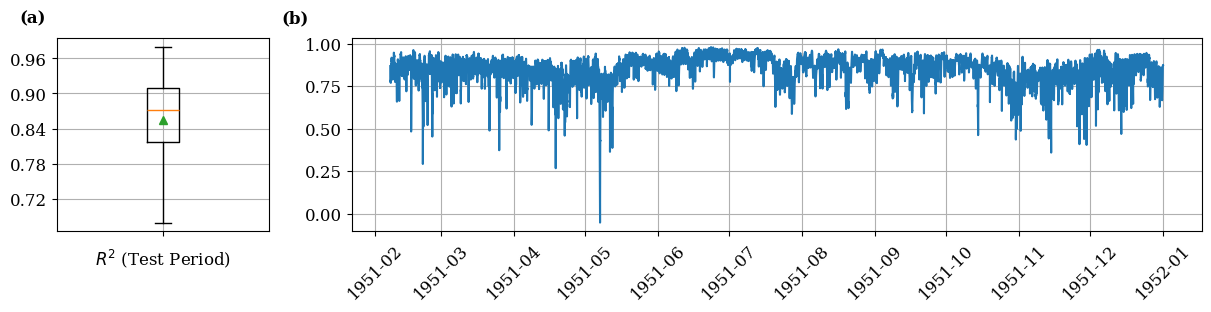

In [9]:
fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

v3 = r_squared_temporal(GTs, PDs)[:]
time = dataset.datetimeindex[:]

ax2.boxplot(v3, showmeans=True, showfliers=False)
ax2.set_xticklabels([])
ax2.set_xlabel(r'$R^2$ (Test Period)')
ax2.yaxis.set_major_locator(MaxNLocator(nbins=6)) 
ax2.text(-0.05, 1.15, '(a)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax2.grid()

ax3.plot(time, v3)
ax3.tick_params(axis='x', labelrotation=45)
ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

if save_figure:
    plt.savefig(osp.join(snapshot_dir, '01-r2_temporal_test.png'))

plt.show()

In [81]:
def r_squared_spatial(gts, pds):

    output = np.empty((gts.shape[1], gts.shape[2]))

    for i in range(gts.shape[1]):
        for j in range(gts.shape[2]):
            output[i, j] = r2_score(gts[:, i, j], pds[:, i, j])
    
    return output

In [47]:
# Define the r_squared_spatial function
def r_squared_spatial(real_data, model_output):
    # Calculate the coefficient of determination (R^2)
    ss_res = np.sum((real_data - model_output) ** 2, axis=0)
    ss_tot = np.sum((real_data - np.mean(real_data, axis=0)) ** 2, axis=0)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [48]:
tr2 = r_squared_spatial(GTs.squeeze(), PDs.squeeze())
GTs = GTs * 0.01 # Convert from kg/kg to microgram/kg
PDs = PDs * 0.01

In [45]:
ds = xr.Dataset({
    'Real Data': (["time", "lat", "lon"], GTs.squeeze()),
    'Model Output': (["time", "lat", "lon"], PDs.squeeze()),
    'Coefficient of Determination': (["lat", "lon"], tr2)

              },
              
     coords=dict(
        time = dataset.datetimeindex,
        lon  = dataset.lon,
        lat  = dataset.lat
    )
)

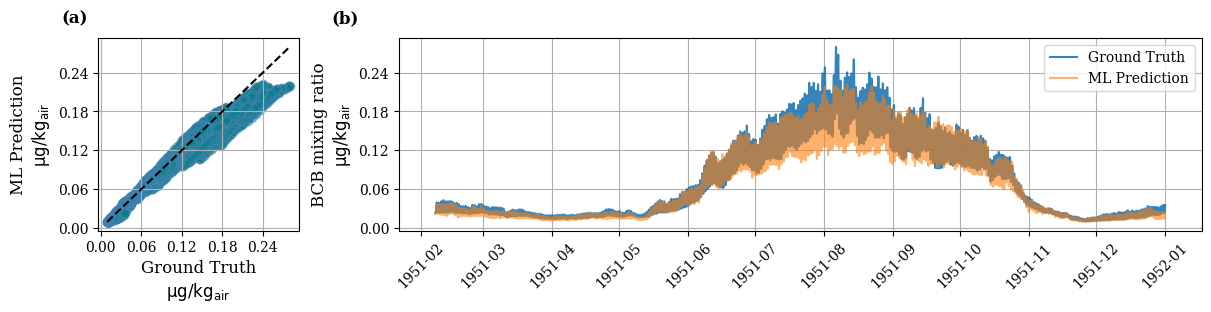

In [62]:
fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))
# ds_monthly_avg = ds_monthly['BCB'].isel(level=0).weighted(weights).mean(dim=("lat", "lon"))

avgGT = ds_avg['Real Data'].values
avgPD = ds_avg['Model Output'].values

max_value = np.array((avgGT, avgPD)).max()
min_value = np.array((avgGT, avgPD)).min()

ax1.scatter(avgGT.ravel(), avgPD.ravel(), color='teal', edgecolor='steelblue', alpha=0.5)
ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

ax1.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax1.xaxis.set_major_locator(MaxNLocator(nbins=5)) 

# BCB mixing ratio

ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)

ax1.text(-0.05, 1.15, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax1.grid()

ax3.plot(dataset.datetimeindex, avgGT, alpha=0.9, label='Ground Truth')
ax3.plot(dataset.datetimeindex, avgPD, alpha=0.6, label='ML Prediction')
# ax3.plot(ds_monthly_avg['time'][-11:], ds_monthly_avg.values[-11:], color='black', marker='o', markersize=3, linestyle='dashed', alpha=0.8,
        #  label='Monthly Average', zorder=5) #TODO -11/-12

ax3.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax3.set_ylabel(r'BCB mixing ratio' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
ax3.tick_params(axis='x', labelrotation=45)

ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

plt.legend()
if save_figure:
    plt.savefig(osp.join(snapshot_dir, '02-global_average.png'))

plt.show()

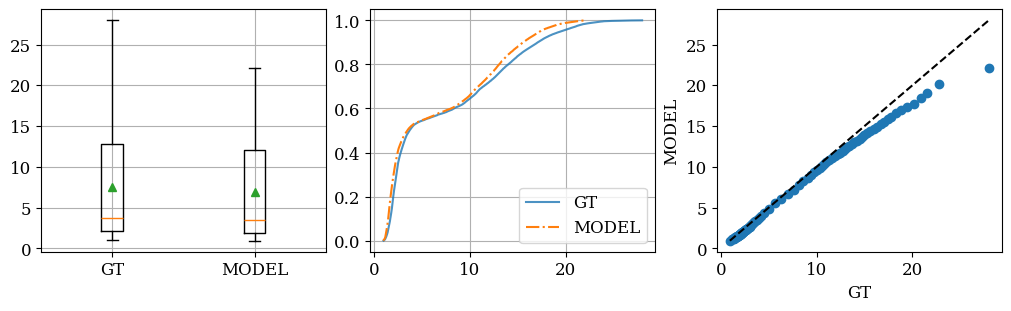

In [26]:
qqplot(avgGT.ravel(), avgPD.ravel(), yax1='' ,axis_names=None, quantiles=100, save_figure=False, fformat=None, saving_path=None)

### Exceedence Probability

In [53]:
def random_sampling(data, n_samples=10000):

    idx = np.arange(len(data.ravel()))

    rng = np.random.default_rng(48)
    rng.shuffle(idx)

    v = data.ravel()[idx[:n_samples]]
    
    return v

def scatter_plot(ax, X, y, scale='linear'):

    v1 = random_sampling(X)
    v2 = random_sampling(y)

    max_value = np.array((v1, v2)).max()

    ax.scatter(v1, v2, color='teal', edgecolor='steelblue', alpha=0.5)
    ax.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

    ax.set_xlabel(r'Ground Truth' '\n' r'BCB ($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)
    ax.set_xscale(scale)

    ax.set_ylabel(r'ML Prediction' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=12)
    ax.set_yscale(scale)

    ax.grid()

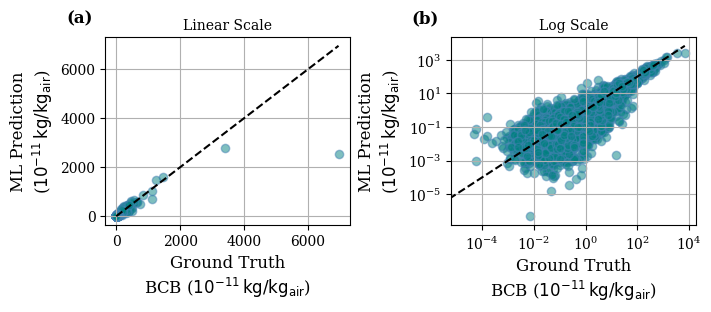

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7, 3), constrained_layout=True)

ax1.set_title('Linear Scale', fontdict={'fontsize': 10})
scatter_plot(ax1, GTs, PDs, scale='linear')
ax1.text(-0.05, 1.15, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

ax2.set_title('Log Scale', fontdict={'fontsize': 10})
scatter_plot(ax2, GTs, PDs, scale='log')
ax2.text(-0.05, 1.15, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

plt.show()

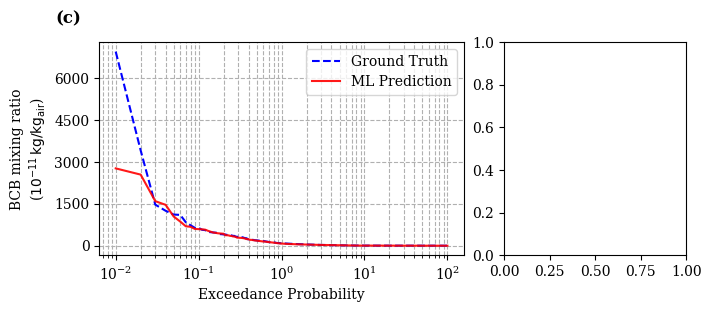

In [62]:
def exceedence_probability(values):
    v = np.array(values)  # Convert to numpy array
    v = -np.sort(-v)  # Sort in descending order
    ep = 100 * np.arange(1, len(v) + 1) / (len(v) + 1)  # Weibull formula
    return v, ep

v1, ep1 = exceedence_probability(random_sampling(GTs))
v2, ep2 = exceedence_probability(random_sampling(PDs))

# In case interpolation is needed
# np.interp(0.05, weibull_exceedance_probability, sorted_flow)

# Create a figure and axis
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(7, 3), constrained_layout=True, gridspec_kw={'width_ratios':[2, 1]})

# Plot the exceedance probabilities
ax.plot(ep1, v1, linestyle='dashed', color='blue', alpha=1.0, label='Ground Truth')
ax.plot(ep2, v2, linestyle='solid', color='red', alpha=0.9, label='ML Prediction')

# Set x-axis to logarithmic scale
ax.set_xscale('log')

ax.yaxis.set_major_locator(MaxNLocator(nbins=6)) 

# Add labels and title
ax.set_ylabel(r'BCB mixing ratio' '\n' r'($10^{-11} \, \mathrm{kg} / \mathrm{kg}_{\mathrm{air}}$)', fontsize=10)
ax.set_xlabel('Exceedance Probability')

ax.text(-0.05, 1.15, '(c)', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

# Add grid, legend, and show the plot
ax.grid(True, which="both", ls="--")
ax.legend()

plt.show()

In [10]:
import geopandas as gpd
import matplotlib.animation as animation

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [47]:
da = ds['Real Data'].isel(time=slice(0, 512)) # 1024 * 0.0417 ~ (1/24) [FPS] 

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(da['lon'], da['lat'])

# Get the data for the current level
data = da.isel(time=5).clip(min=1E-3).pipe(np.log10)

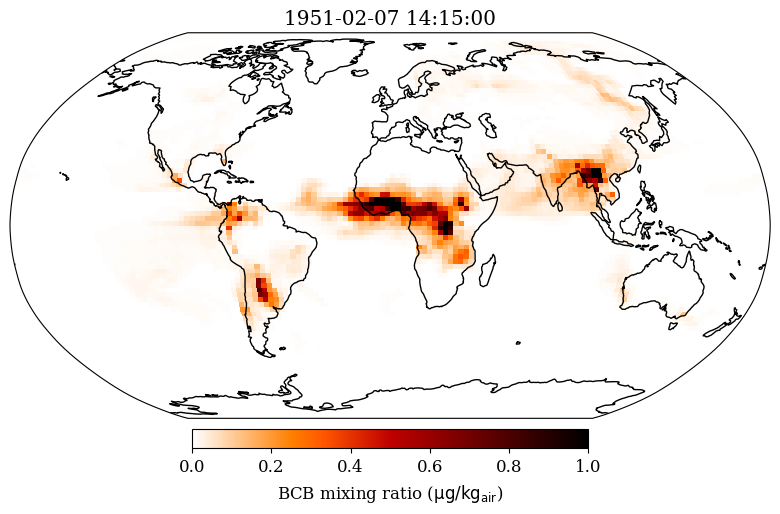

In [48]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

data = da.isel(time=5).clip(min=1E-3) # .pipe(np.log10)

# Convert to pandas Timestamp
timestamp = pd.Timestamp(data['time'].values)

# Format the Timestamp to a readable string
readable_date = timestamp.strftime('%Y-%m-%d %H:%M:%S')
ax.set_title(f'{readable_date}')

ax.coastlines()

# Plot the data using pcolormesh, which works better with projections
im = ax.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap='gist_heat_r',
    vmin=0, vmax=1
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.5)
cbar.set_label(r'BCB mixing ratio ($\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$)', rotation=0, labelpad=5, fontsize=12)
cbar.ax.tick_params(labelsize=12)  # Adjust the font size here

plt.show()

In [49]:
def plot_time_frame(da, t_idx):
    
    data = da.isel(time=t_idx).clip(min=1E-3) #.pipe(np.log10)

    # Convert to pandas Timestamp
    timestamp = pd.Timestamp(data['time'].values)

    # Format the Timestamp to a readable string
    readable_date = timestamp.strftime('%Y-%m-%d %H:%M:%S')

    plt.clf()
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()

    ax.set_title(f'{readable_date}')

    # Plot the data using pcolormesh, which works better with projections
    im = ax.pcolormesh(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap='gist_heat_r',
        vmin=0, vmax=1
    )

    # Add an individual colorbar for each subplot
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
    cbar.set_label(r'BCB mixing ratio ($\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$)', rotation=0, labelpad=5, fontsize=12)
    cbar.ax.tick_params(labelsize=12)  # Adjust the font size here

MovieWriter ffmpeg unavailable; using Pillow instead.


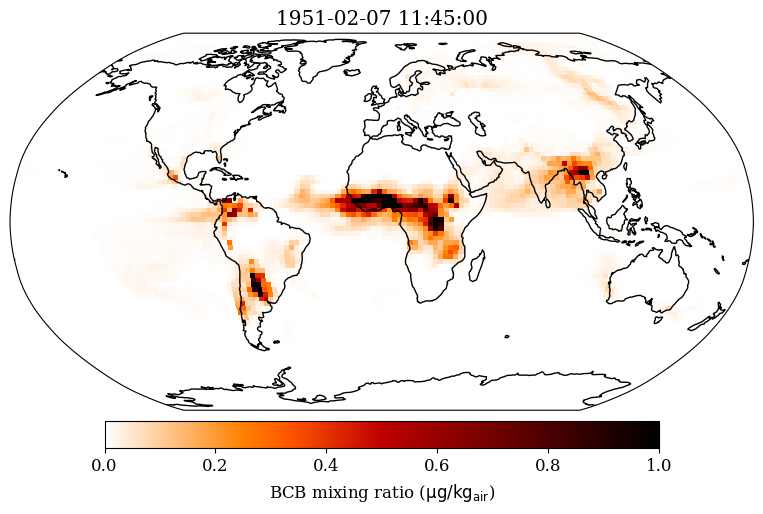

In [50]:
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

def update(frame):
    plot_time_frame(da, frame)

# Create animation
anim = animation.FuncAnimation(fig, update, frames=len(da.time), interval=42, blit=False, repeat=False)

# Save animation as MP4
anim.save('anim_gt_clip_log.gif', writer='ffmpeg')

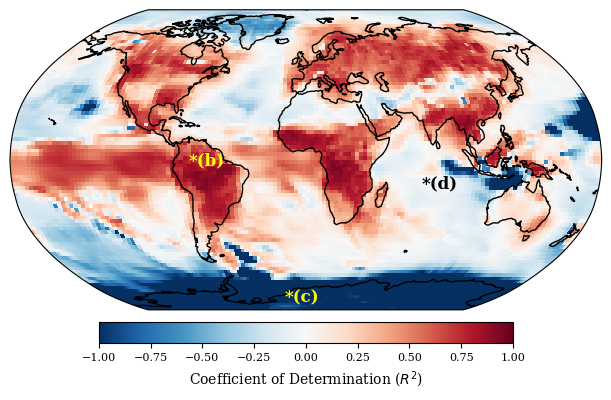

In [46]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax.coastlines()

# Get the data for the current level
data = ds['Coefficient of Determination']

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im = ax.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1.0, vmax=1.0
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

# # Adjust the colorbar's position and size
# cbar.ax.set_position([0.45, 0.2, 0.02, 0.3])  # [left, bottom, width, height]

# world.boundary.plot(ax=plt.gca(), alpha=0.7, color='black', linewidth=0.5, transform=ccrs.PlateCarree())

# ax.text(-0.00, 1.06, '(a)', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')

ax.text(-71.25, -3.0, '*(b)', fontsize=12, color='yellow', fontweight='bold', transform=ccrs.PlateCarree())
ax.text(-21.25, -81.0, '*(c)', fontsize=12, color='yellow', fontweight='bold', transform=ccrs.PlateCarree())
ax.text(71.25, -15.0, '*(d)', fontsize=12, color='black', fontweight='bold', transform=ccrs.PlateCarree())


# world.boundary.plot(ax=plt.gca(), alpha=0.7, color='black', linewidth=0.5, transform=ccrs.PlateCarree())
# fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

if save_figure:
    plt.savefig(osp.join(snapshot_dir, '03-r2_spatial_test.png'))

plt.show()

In [ ]:
feb = ds.sel(time=ds['time'].dt.month == 2)
r_squared = r_squared_spatial(feb['Real Data'].values, feb['Model Output'].values)
feb['Coefficient of Determination'] = (('lat', 'lon'), r_squared)

aug = ds.sel(time=ds['time'].dt.month == 8)
r_squared = r_squared_spatial(aug['Real Data'].values, aug['Model Output'].values)
aug['Coefficient of Determination'] = (('lat', 'lon'), r_squared)

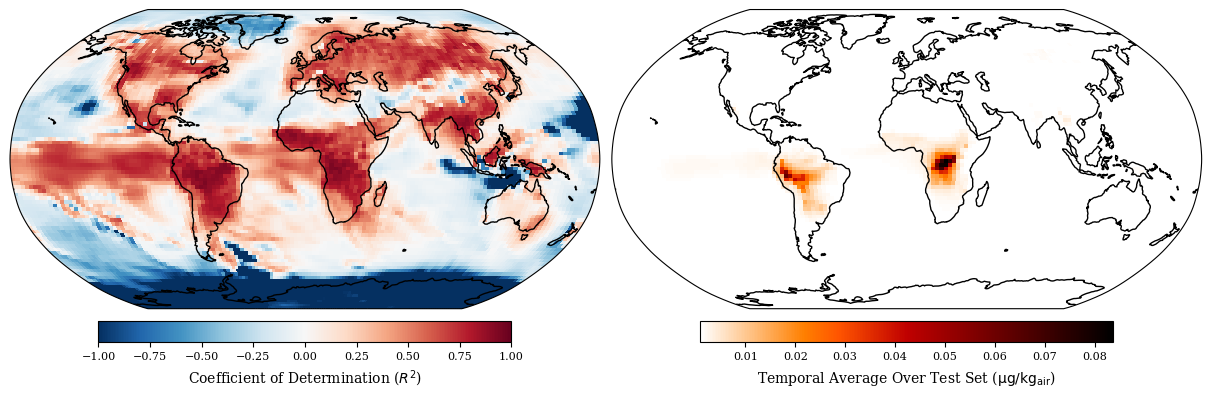

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax1.coastlines()

# Get the data for the current level
data1 = ds['Coefficient of Determination']

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im1 = ax1.pcolormesh(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1.0, vmax=1.0
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here


ax2.coastlines()

# Get the data for the current level
data2 = ds['Real Data'].mean(dim='time').clip(min=1E-3)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im2 = ax2.pcolormesh(
    lon, lat, data2,
    transform=ccrs.PlateCarree(),
    cmap='gist_heat_r',
    # vmin=0, vmax=0.08
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here


plt.show()

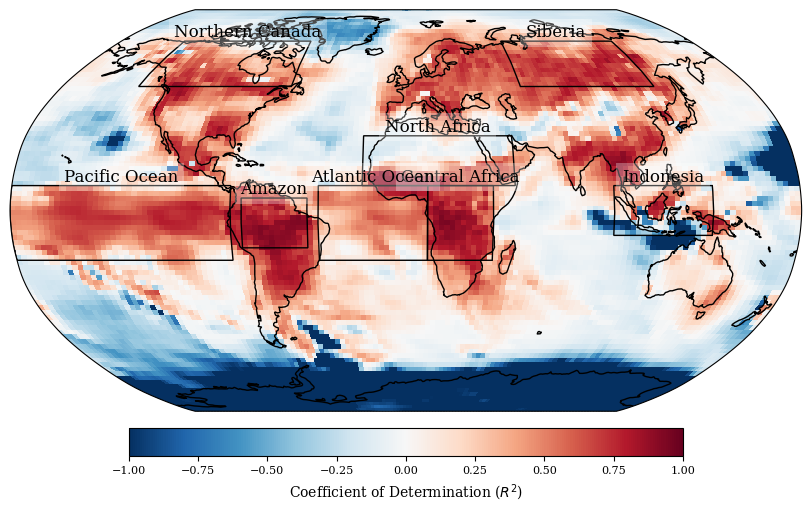

In [101]:

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 8), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax.coastlines()

# Get the data for the current level
data = ds['Coefficient of Determination']

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
im = ax.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-1.0, vmax=1.0
)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

# Define the regions with their latitude and longitude ranges
regions = {
    'Amazon': {'lat': (-15.0, 5.0), 'lon': (-75.0, -45.0)},
    'North Africa': {'lat': (10.0, 30.0), 'lon': (-20.0, 50.0)},
    'Central Africa': {'lat': (-20.0, 10.0), 'lon': (10.0, 40.0)},
    'Indonesia': {'lat': (-10.0, 10.0), 'lon': (95.0, 140.0)},
    'Siberia': {'lat': (50.0, 70.0), 'lon': (60.0, 130.0)},
    'Northern Canada': {'lat': (50.0, 70.0), 'lon': (-140.0, -60.0)},
    'Atlantic Ocean': {'lat': (-20.0, 10.0), 'lon': (-40.0, 10.0)},
    'Pacific Ocean': {'lat': (-20.0, 10.0), 'lon': (-180.0, -80.0)}
}

# Add patches for each region
for region, coords in regions.items():
    lat_range = coords['lat']
    lon_range = coords['lon']
    rect = patches.Rectangle(
        (lon_range[0], lat_range[0]),
        lon_range[1] - lon_range[0],
        lat_range[1] - lat_range[0],
        linewidth=1,
        edgecolor='black',
        facecolor='none',
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(rect)
    ax.text(
        lon_range[0] + (lon_range[1] - lon_range[0]) / 2,
        lat_range[1],
        region,
        horizontalalignment='center',
        verticalalignment='bottom',
        transform=ccrs.PlateCarree(),
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.3, edgecolor='none')  # Set alpha for transparency
    )

plt.show()

In [83]:
atlantic_ocean

<xarray.Dataset> Size: 126kB
Dimensions:                       (time: 15721, lat: 0, lon: 20)
Coordinates:
  * time                          (time) datetime64[ns] 126kB 1951-02-07T11:4...
  * lon                           (lon) float32 80B -38.75 -36.25 ... 6.25 8.75
  * lat                           (lat) float32 0B 
Data variables:
    Real Data                     (time, lat, lon) float64 0B 
    Model Output                  (time, lat, lon) float64 0B 
    Coefficient of Determination  (lat, lon) float64 0B

In [85]:
amazon = ds.sel(lat=slice(-15.0, 5.0), lon=slice(-75.0, -45.0))
amazon_feb = amazon.sel(time=amazon['time'].dt.month == 2)
amazon_aug = amazon.sel(time=amazon['time'].dt.month == 8)

north_africa = ds.sel(lat=slice(10.0, 30.0), lon=slice(-20.0, 50.0))
north_africa_feb = north_africa.sel(time=north_africa['time'].dt.month == 2)
north_africa_aug = north_africa.sel(time=north_africa['time'].dt.month == 8)

central_africa = ds.sel(lat=slice(-20.0, 10.0), lon=slice(10.0, 40.0))
central_africa_feb = central_africa.sel(time=central_africa['time'].dt.month == 2)
central_africa_aug = central_africa.sel(time=central_africa['time'].dt.month == 8)

indonesia = ds.sel(lat=slice(-10.0, 10.0), lon=slice(95.0, 140.0))
indonesia_feb = indonesia.sel(time=indonesia['time'].dt.month == 2)
indonesia_aug = indonesia.sel(time=indonesia['time'].dt.month == 8)

siberia = ds.sel(lat=slice(50.0, 70.0), lon=slice(60.0, 130.0))
siberia_feb = siberia.sel(time=siberia['time'].dt.month == 2)
siberia_aug = siberia.sel(time=siberia['time'].dt.month == 8)

northern_canada = ds.sel(lat=slice(50.0, 70.0), lon=slice(-140.0, -60.0))
northern_canada_feb = northern_canada.sel(time=northern_canada['time'].dt.month == 2)
northern_canada_aug = northern_canada.sel(time=northern_canada['time'].dt.month == 8)

atlantic_ocean = ds.sel(lat=slice(-20.0, 10.0), lon=slice(-40.0, 10.0))
atlantic_ocean_feb = atlantic_ocean.sel(time=atlantic_ocean['time'].dt.month == 2)
atlantic_ocean_aug = atlantic_ocean.sel(time=atlantic_ocean['time'].dt.month == 8)

pacific_ocean = ds.sel(lat=slice(-20.0, 10.0), lon=slice(-180.0, -80.0))
pacific_ocean_feb = pacific_ocean.sel(time=pacific_ocean['time'].dt.month == 2)
pacific_ocean_aug = pacific_ocean.sel(time=pacific_ocean['time'].dt.month == 8)

# Calculate and print the mean R^2 values
print('Amazon 1951:', f'{r_squared_spatial(amazon["Real Data"].values, amazon["Model Output"].values).mean():.2f}')
print('Amazon February:', f'{r_squared_spatial(amazon_feb["Real Data"].values, amazon_feb["Model Output"].values).mean():.2f}')
print('Amazon August:', f'{r_squared_spatial(amazon_aug["Real Data"].values, amazon_aug["Model Output"].values).mean():.2f}')

print('North Africa 1951:', f'{r_squared_spatial(north_africa["Real Data"].values, north_africa["Model Output"].values).mean():.2f}')
print('North Africa February:', f'{r_squared_spatial(north_africa_feb["Real Data"].values, north_africa_feb["Model Output"].values).mean():.2f}')
print('North Africa August:', f'{r_squared_spatial(north_africa_aug["Real Data"].values, north_africa_aug["Model Output"].values).mean():.2f}')

print('Central Africa 1951:', f'{r_squared_spatial(central_africa["Real Data"].values, central_africa["Model Output"].values).mean():.2f}')
print('Central Africa February:', f'{r_squared_spatial(central_africa_feb["Real Data"].values, central_africa_feb["Model Output"].values).mean():.2f}')
print('Central Africa August:', f'{r_squared_spatial(central_africa_aug["Real Data"].values, central_africa_aug["Model Output"].values).mean():.2f}')

print('Indonesia 1951:', f'{r_squared_spatial(indonesia["Real Data"].values, indonesia["Model Output"].values).mean():.2f}')
print('Indonesia February:', f'{r_squared_spatial(indonesia_feb["Real Data"].values, indonesia_feb["Model Output"].values).mean():.2f}')
print('Indonesia August:', f'{r_squared_spatial(indonesia_aug["Real Data"].values, indonesia_aug["Model Output"].values).mean():.2f}')

print('Siberia 1951:', f'{r_squared_spatial(siberia["Real Data"].values, siberia["Model Output"].values).mean():.2f}')
print('Siberia February:', f'{r_squared_spatial(siberia_feb["Real Data"].values, siberia_feb["Model Output"].values).mean():.2f}')
print('Siberia August:', f'{r_squared_spatial(siberia_aug["Real Data"].values, siberia_aug["Model Output"].values).mean():.2f}')

print('Northern Canada 1951:', f'{r_squared_spatial(northern_canada["Real Data"].values, northern_canada["Model Output"].values).mean():.2f}')
print('Northern Canada February:', f'{r_squared_spatial(northern_canada_feb["Real Data"].values, northern_canada_feb["Model Output"].values).mean():.2f}')
print('Northern Canada August:', f'{r_squared_spatial(northern_canada_aug["Real Data"].values, northern_canada_aug["Model Output"].values).mean():.2f}')

print('Atlantic Ocean 1951:', f'{r_squared_spatial(atlantic_ocean["Real Data"].values, atlantic_ocean["Model Output"].values).mean():.2f}')
print('Atlantic Ocean February:', f'{r_squared_spatial(atlantic_ocean_feb["Real Data"].values, atlantic_ocean_feb["Model Output"].values).mean():.2f}')
print('Atlantic Ocean August:', f'{r_squared_spatial(atlantic_ocean_aug["Real Data"].values, atlantic_ocean_aug["Model Output"].values).mean():.2f}')

print('Pacific Ocean 1951:', f'{r_squared_spatial(pacific_ocean["Real Data"].values, pacific_ocean["Model Output"].values).mean():.2f}')
print('Pacific Ocean February:', f'{r_squared_spatial(pacific_ocean_feb["Real Data"].values, pacific_ocean_feb["Model Output"].values).mean():.2f}')
print('Pacific Ocean August:', f'{r_squared_spatial(pacific_ocean_aug["Real Data"].values, pacific_ocean_aug["Model Output"].values).mean():.2f}')

Amazon 1951: 0.77
Amazon February: -0.56
Amazon August: 0.16
North Africa 1951: 0.27
North Africa February: -0.25
North Africa August: -0.50
Central Africa 1951: 0.74
Central Africa February: -1.41
Central Africa August: 0.35
Indonesia 1951: -0.05
Indonesia February: -2.05
Indonesia August: -11.30
Siberia 1951: 0.64
Siberia February: -0.24
Siberia August: 0.44
Northern Canada 1951: 0.37
Northern Canada February: -1.04
Northern Canada August: 0.23
Atlantic Ocean 1951: 0.39
Atlantic Ocean February: -4.56
Atlantic Ocean August: -0.33
Pacific Ocean 1951: 0.50
Pacific Ocean February: -9.39
Pacific Ocean August: -0.54


In [90]:
def plot_on_region(ds):

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))

    from matplotlib import rcParams
    from matplotlib.ticker import MaxNLocator
    rcParams['font.size'] = 10  # Set the default font size
    
    fig, ax = plt.subplots(figsize=(10, 3))
    
    # Rename columns directly in the plot command
    ax.plot(ds_avg['time'], ds_avg['Real Data'], label='Ground Truth', alpha=1.0)
    ax.plot(ds_avg['time'], ds_avg['Model Output'], label='ML Prediction', alpha=0.6)
    
    # Set x-ticks to display month names
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45) # labelsize=14)

    # ax.set_ylabel(r'BCB mixing ratio' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 

    # ax.text(-0.05, 1.08, f'({fig_num})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    
    # Adjust the font size of the legend
    ax.legend(fontsize=12)  # Set the desired font size for the legend
    ax.grid(True)
    
    plt.show()

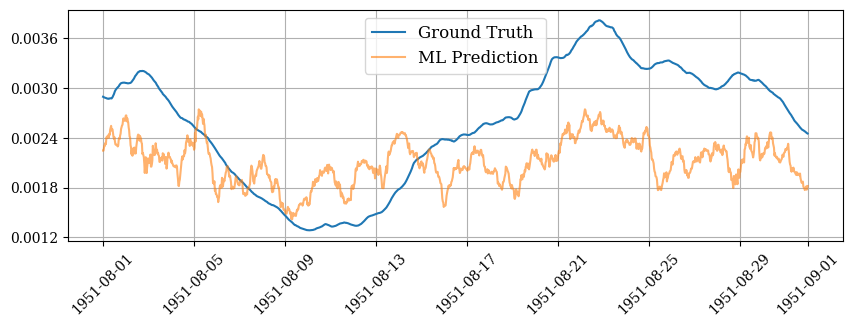

In [117]:
plot_on_region(pacific_ocean_aug)

### Zonal analysis: across different latitude bands

In [19]:
ds['Weight'] = ds['Real Data'].mean(dim='time')
ds['Weighted Coefficient of Determination'] = ds['Weight'] * ds['Coefficient of Determination']

# Assuming ds is your xarray Dataset and 'Coefficient of Determination' is the DataArray you want to plot
tropical_latitudes = ds['Weighted Coefficient of Determination'].sel(lat=slice(-21, 21)).sum() / ds['Weight'].sel(lat=slice(-21, 21)).sum()
northern_mid_latitudes = ds['Weighted Coefficient of Determination'].sel(lat=slice(21, 61)).sum() / ds['Weight'].sel(lat=slice(21, 61)).sum()
northern_polar_latitudes = ds['Weighted Coefficient of Determination'].sel(lat=slice(61, 90)).sum() / ds['Weight'].sel(lat=slice(61, 90)).sum()
southern_mid_latitudes = ds['Weighted Coefficient of Determination'].sel(lat=slice(-61, -21)).sum() / ds['Weight'].sel(lat=slice(-61, -21)).sum()
southern_polar_latitudes = ds['Weighted Coefficient of Determination'].sel(lat=slice(-90, -61)).sum() / ds['Weight'].sel(lat=slice(-90, -61)).sum()


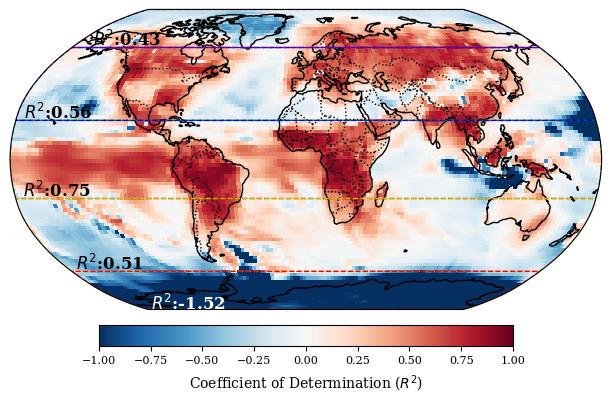

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})

# Plot the data
ds['Coefficient of Determination'].plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=-1.0, vmax=1.0, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.coastlines()

# Define the latitude zones
tropical_zone = patches.Rectangle((-180, -21), 360, 42, linewidth=1, edgecolor='green', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
ax.text(-175, -20, rf'$R^2$:{tropical_latitudes.values:.2f}', fontsize=12, color='black', fontweight='bold', transform=ccrs.PlateCarree())

northern_mid_latitude_zone = patches.Rectangle((-180, 21), 360, 40, linewidth=1, edgecolor='blue', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
ax.text(-175, 22, rf'$R^2$:{northern_mid_latitudes.values:.2f}', fontsize=12, color='black', fontweight='bold', transform=ccrs.PlateCarree())

northern_polar_zone = patches.Rectangle((-180, 61), 360, 29, linewidth=1, edgecolor='purple', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
ax.text(-165, 62, rf'$R^2$:{northern_polar_latitudes.values:.2f}', fontsize=12, color='black', fontweight='bold', transform=ccrs.PlateCarree())

southern_mid_latitude_zone = patches.Rectangle((-180, -61), 360, 40, linewidth=1, edgecolor='orange', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
ax.text(-175, -60, rf'$R^2$:{southern_mid_latitudes.values:.2f}', fontsize=12, color='black', fontweight='bold', transform=ccrs.PlateCarree())

southern_polar_zone = patches.Rectangle((-180, -90), 360, 29, linewidth=1, edgecolor='red', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
ax.text(-175, -89, rf'$R^2$:{southern_polar_latitudes.values:.2f}', fontsize=12, color='white', fontweight='bold', transform=ccrs.PlateCarree())

# Add the latitude zones to the plot
ax.add_patch(tropical_zone)
ax.add_patch(northern_mid_latitude_zone)
ax.add_patch(northern_polar_zone)
ax.add_patch(southern_mid_latitude_zone)
ax.add_patch(southern_polar_zone)

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

# Show the plot
plt.show()

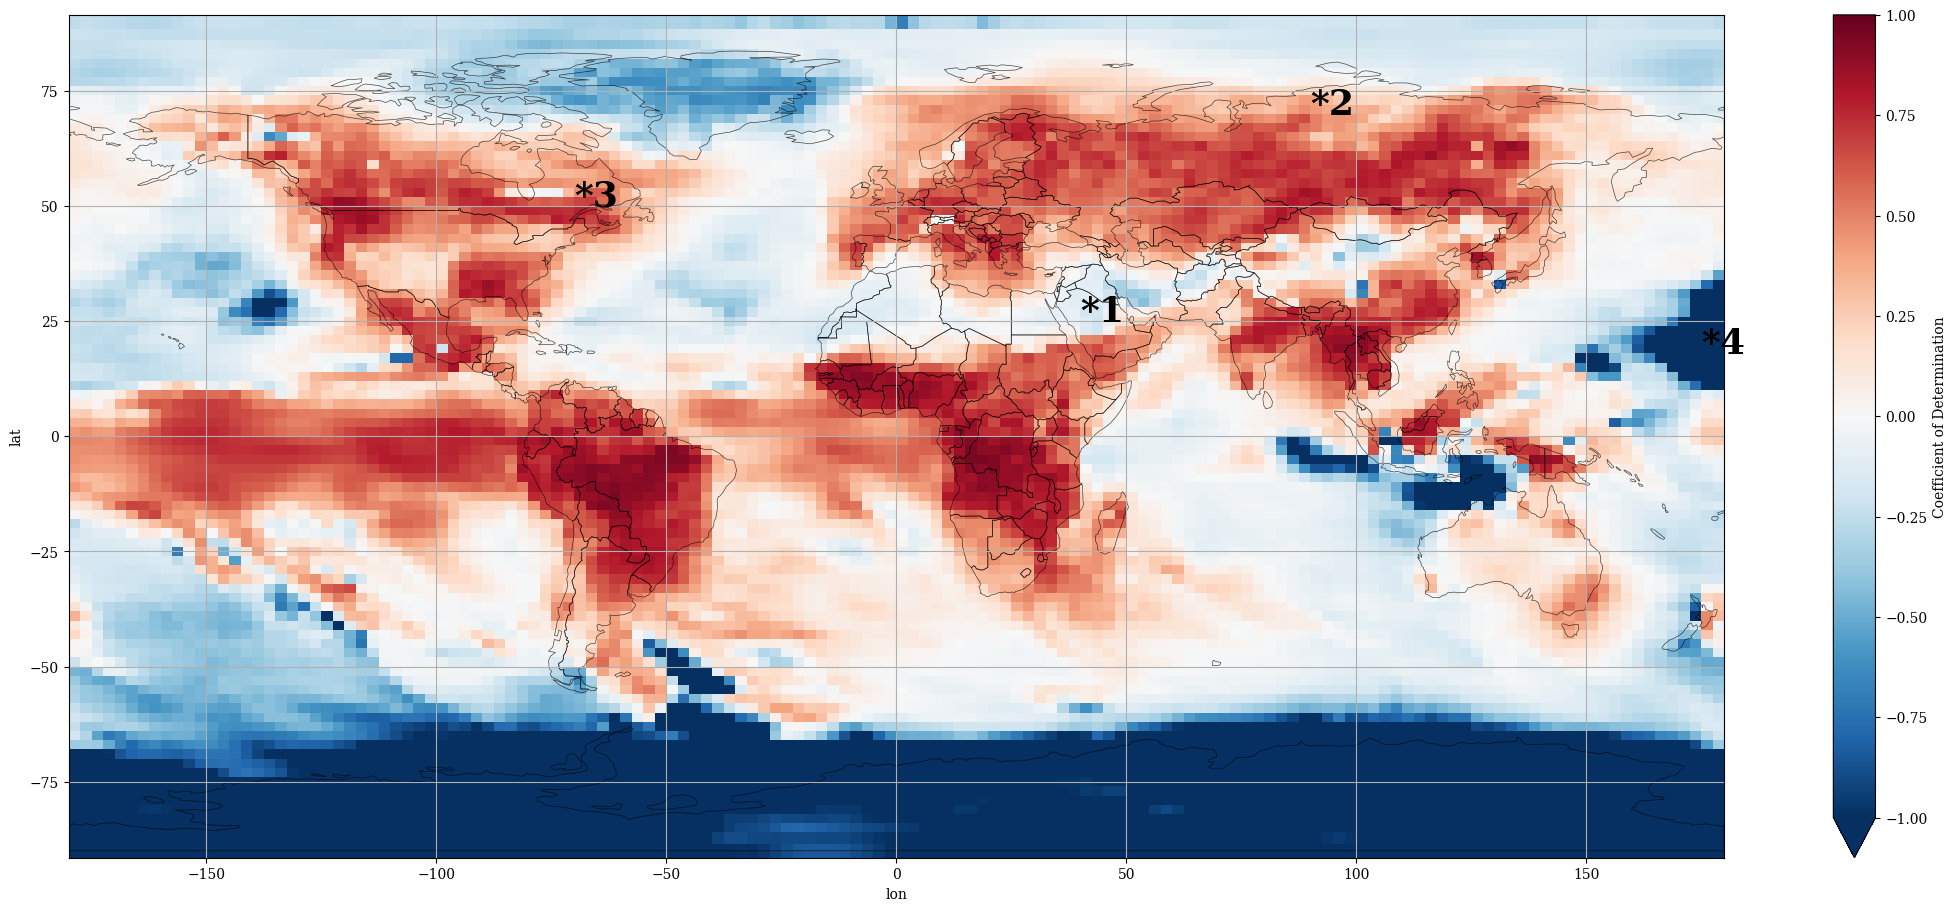

In [51]:
import cartopy
fig, ax = plt.subplots(figsize=(20, 9), constrained_layout=True)

# Plot the data
ds['Coefficient of Determination'].plot(ax=ax, add_colorbar=True, cmap='RdBu_r', vmin=-1.0, vmax=1.0)
world.boundary.plot(ax=ax, alpha=0.7, color='black', linewidth=0.5, zorder=1)

ax.text(40, 25, '*1', fontsize=26, color='black', fontweight='bold')
ax.text(90, 70, '*2', fontsize=26, color='black', fontweight='bold')
ax.text(-70, 50, '*3', fontsize=26, color='black', fontweight='bold')
ax.text(175, 18, '*4', fontsize=26, color='black', fontweight='bold')

# Show the plot
plt.grid()
plt.show()

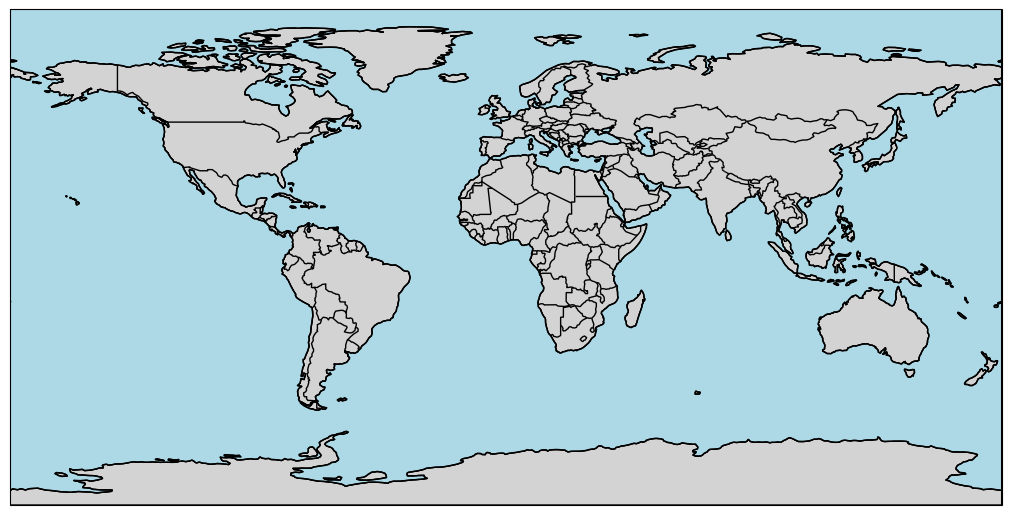

In [28]:
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(10, 7), constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean features with specified face colors
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='black')

# Add country boundaries
ax.add_feature(cfeature.BORDERS, edgecolor='black')

# Add coastlines
ax.coastlines()

# Show the plot
plt.grid()
plt.show()

In [65]:
df = ds.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
gdf = df.groupby(['lat', 'lon'])
df.head()

,lat,lon,time,Real Data,Model Output,Coefficient of Determination
0,-90.0,-178.75,1951-02-07 11:45:00,0.000051,-0.000075,-1.868223
1,-90.0,-178.75,1951-02-07 12:15:00,0.000051,-0.000066,-1.868223
2,-90.0,-178.75,1951-02-07 12:45:00,0.000051,-0.000081,-1.868223
3,-90.0,-178.75,1951-02-07 13:15:00,0.000051,-0.000096,-1.868223
4,-90.0,-178.75,1951-02-07 13:45:00,0.000052,-0.000078,-1.868223


In [68]:
def plot_on_grid(gdf, lat, lon, fig_num):

    from matplotlib import rcParams
    from matplotlib.ticker import MaxNLocator
    rcParams['font.size'] = 10  # Set the default font size

    g = gdf.get_group((lat, lon))
    g = g.sort_values('time')

    r2 = g['Coefficient of Determination'].iloc[0]
    print(f'exact coordinates, lat:{lat}, lon:{lon}, R2H: {r2:.2f}')
    
    fig, ax = plt.subplots(figsize=(8, 2))
    
    # Rename columns directly in the plot command
    ax.plot(g['time'], g['Real Data'], label='Ground Truth', alpha=1.0)
    ax.plot(g['time'], g['Model Output'], label='ML Prediction', alpha=0.6)
    
    # Set x-ticks to display month names
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation=45) # labelsize=14)


    # ax.set_ylabel(r'BCB mixing ratio' '\n' r'$\mathrm{\mu g} / \mathrm{kg}_{\mathrm{air}}$', fontsize=12)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5)) 

    # ax.text(-0.05, 1.08, f'({fig_num})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    
    # Adjust the font size of the legend
    ax.legend(fontsize=12)  # Set the desired font size for the legend
    ax.grid(True)
    
    plt.show()

exact coordinates, lat:25.0, lon:38.75, R2H: -0.08


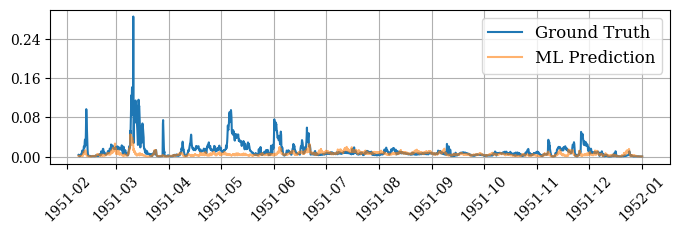

In [69]:
lat, lon = find_nearest(df[['lat', 'lon']], 25, 40)
plot_on_grid(gdf, lat, lon, 'b')

exact coordinates, lat:69.0, lon:88.75, R2H: 0.65


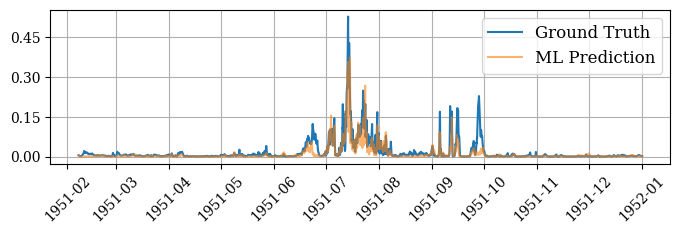

In [70]:
lat, lon = find_nearest(df[['lat', 'lon']], 70, 90)
plot_on_grid(gdf, lat, lon, 'c')

exact coordinates, lat:49.0, lon:-71.25, R2H: 0.73


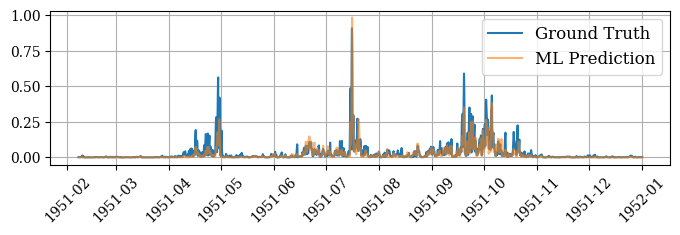

In [71]:
lat, lon = find_nearest(df[['lat', 'lon']], 50, -70)
plot_on_grid(gdf, lat, lon, 'd')

exact coordinates, lat:-3.0, lon:-71.25, R2H: 0.87


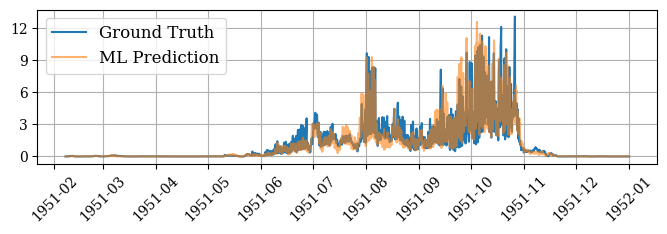

In [72]:

lat, lon = find_nearest(df[['lat', 'lon']], -2, -70)
plot_on_grid(gdf, lat, lon, 'b')

exact coordinates, lat:-81.0, lon:-21.25, R2H: -1.08


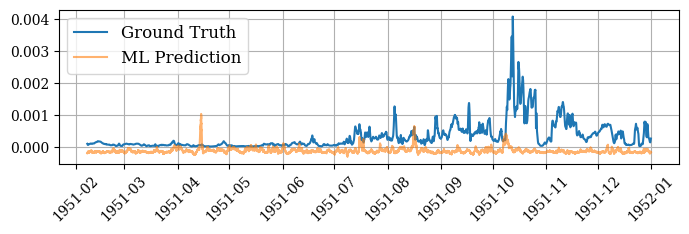

In [73]:
lat, lon = find_nearest(df[['lat', 'lon']], -80, -20)
plot_on_grid(gdf, lat, lon, 'c')

### One-at-a-Time (OAT) sensitivity analysis 

In [18]:
from tqdm import tqdm

# Parameters
num_ftrs = 5
perturbed_values = 0.05

# Preallocation
PDs_perturbed = np.empty((num_ftrs, *PDs.shape))

net.eval()

with torch.no_grad():
    for i in tqdm(range(num_ftrs)):
        
        sample_index = 0
        for counter, (X, y) in enumerate(dataloader, 1):
            current_batch_size = X.shape[0]
            
            X[:, :, i] *= (1 + perturbed_values)
            X = X.cuda()

            pred = net(X)

            if model.split('-')[0] in ['PIX2PIX', 'UNet']:
                p = pred[:, :, 83:83+90, 56:56+144].clone()
            
            elif model.split('-')[0] in ['LSTM']:
                p = pred[:, :, 5:5+90, 5:5+144].clone().squeeze()

            # Detach the output from computational graph ad deploy it to CPU as a numpy array
            p = (p.detach().cpu().numpy() * dataset.y_std) + dataset.y_mean
            
            PDs_perturbed[i, sample_index:sample_index+batch_size] = p
            
            sample_index += current_batch_size
            
    print(PDs_perturbed.shape)

100%|██████████| 5/5 [01:54<00:00, 22.94s/it]

(5, 818, 1, 90, 144)


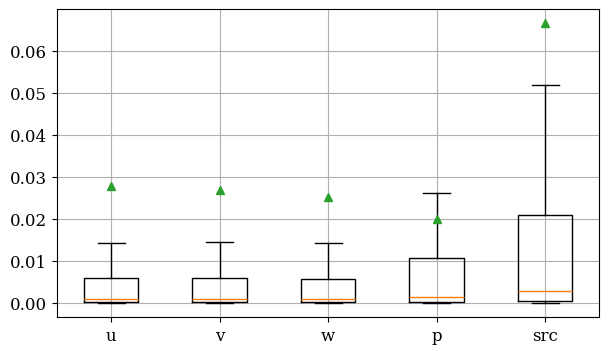

In [19]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.boxplot(np.abs(PDs_perturbed - PDs).reshape(5, -1).T, showmeans=True, showfliers=False)
ax.set_xticklabels(['u', 'v', 'w', 'p', 'src'])

ax.grid()

if save_figure:
    plt.savefig(osp.join(snapshot_dir, '04-sensitivity_analysis.png'))

plt.show()

In [6]:
summary(net, torch.randn((1, 48, 5, 100, 154))) # (1, 5, 256, 256), (1, 48, 5, 100, 154)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─ConvLSTMCell: 2-1                 [-1, 64, 100, 154]        --
|    |    └─Conv2d: 3-1                  [-1, 256, 100, 154]       441,856
|    |    └─Sigmoid: 3-2                 [-1, 64, 100, 154]        --
|    |    └─Sigmoid: 3-3                 [-1, 64, 100, 154]        --
|    |    └─Tanh: 3-4                    [-1, 64, 100, 154]        --
|    |    └─Sigmoid: 3-5                 [-1, 64, 100, 154]        --
|    |    └─Tanh: 3-6                    [-1, 64, 100, 154]        --
|    └─ConvLSTMCell: 2-2                 [-1, 32, 100, 154]        --
|    |    └─Conv2d: 3-7                  [-1, 128, 100, 154]       110,720
|    |    └─Sigmoid: 3-8                 [-1, 32, 100, 154]        --
|    |    └─Sigmoid: 3-9                 [-1, 32, 100, 154]        --
|    |    └─Tanh: 3-10                   [-1, 32, 100, 154]        --
|    

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─ConvLSTMCell: 2-1                 [-1, 64, 100, 154]        --
|    |    └─Conv2d: 3-1                  [-1, 256, 100, 154]       441,856
|    |    └─Sigmoid: 3-2                 [-1, 64, 100, 154]        --
|    |    └─Sigmoid: 3-3                 [-1, 64, 100, 154]        --
|    |    └─Tanh: 3-4                    [-1, 64, 100, 154]        --
|    |    └─Sigmoid: 3-5                 [-1, 64, 100, 154]        --
|    |    └─Tanh: 3-6                    [-1, 64, 100, 154]        --
|    └─ConvLSTMCell: 2-2                 [-1, 32, 100, 154]        --
|    |    └─Conv2d: 3-7                  [-1, 128, 100, 154]       110,720
|    |    └─Sigmoid: 3-8                 [-1, 32, 100, 154]        --
|    |    └─Sigmoid: 3-9                 [-1, 32, 100, 154]        --
|    |    └─Tanh: 3-10                   [-1, 32, 100, 154]        --
|    

In [7]:
%%timeit
net.cuda()(torch.randn((1, 48, 5, 100, 154)).cuda())

38.7 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
net.cpu()(torch.randn((1, 48, 5, 100, 154)))

668 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparing Global Avg of BCB Conc. for 1950 vs. 1951

In [41]:
for root, dirs, files in os.walk('/home/serfani/serfani_data0/E33OMA'):
    
    sorted_files = sorted(files)
    list1 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'aijlh1E33oma_ai']   # Velocity Fields (time, level, lat, lon)
    list2 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'cijh1E33oma_ai']    # Precipitation (time, lat, lon)
    list3 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijh1E33oma_ai']   # Sea Salt Src (time, lat, lon)
    list4 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'tNDaijh1E33oma_ai'] # Clay-BCB Src (time, lat, lon)
    list5 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'taijlh1E33oma_ai']  # Aerosols Mixing Ratio (time, level, lat, lon)


In [44]:
ds = xr.open_mfdataset(list5)
var = 'BCB' # 'Clay', 'seasalt1', 'BCB'

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

if ds[var].ndim == 3:
    ds = ds.weighted(weights).mean(dim=("lat", "lon"))

if ds[var].ndim == 4:    
    ds = ds.isel(level=0).weighted(weights).mean(dim=("lat", "lon"))


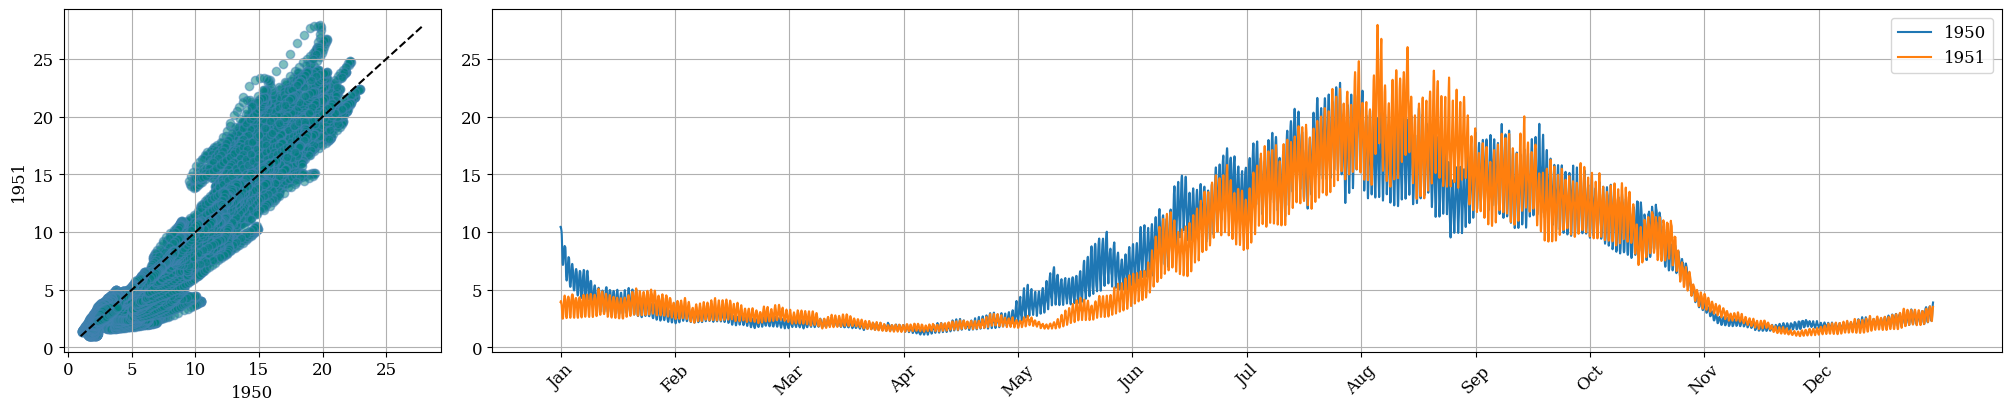

In [58]:
plot_global_ave(ds['BCB'], save_figure=False, fformat=None, saving_path=None)

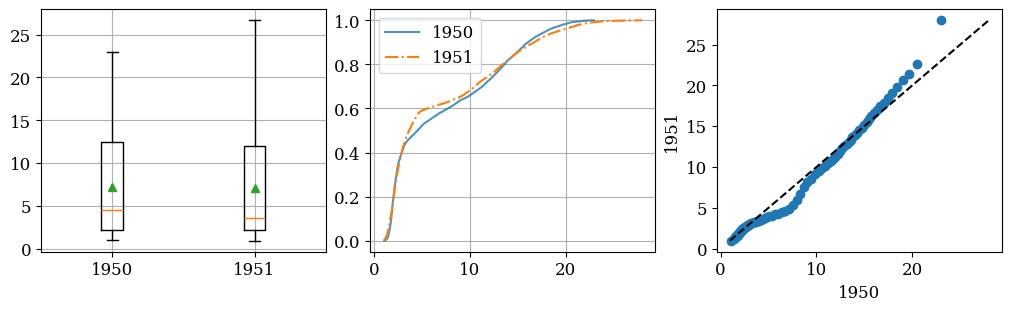

In [54]:
qqplot(ds['BCB'].isel(time=slice(0, 17520)).values, ds['BCB'].isel(time=slice(17520, None)).values, yax1='' ,axis_names=('1950', '1951'), quantiles=100)

In [2]:
# Example usage
input_channels = 5
hidden_channels = [64, 32, 16]
kernel_size = [5, 3, 3]
num_layers = 3

model = ConvLSTM(input_channels, hidden_channels, kernel_size, num_layers)

# Calculate the number of trainable parameters
print([p.numel() for p in model.parameters() if p.requires_grad])
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of trainable parameters: {num_params}')

[441600, 256, 110592, 128, 27648, 64, 16, 1]
Total number of trainable parameters: 580305
